In [1]:
using FermiCG
using PyCall
using Plots
using LinearAlgebra
using Printf

Define molecule and run HF

In [2]:
molecule = "
 C     4.93354    -2.84833     0.00000
 C     4.93321    -1.45861     0.00000
 C     3.73075    -0.73168     0.00000
 C     2.49032    -1.43783     0.00000
 C     1.23513    -0.71311     0.00000
 C     1.23513     0.71311     0.00000
 C     2.49032     1.43783     0.00000
 C     3.73075     0.73168     0.00000
 C     4.93321     1.45861     0.00000
 C     4.93354     2.84833     0.00000
 C     3.72991     3.54302     0.00000
 C     2.49908     2.86514     0.00000
 C     1.23174     3.59686    -0.00000
 C     1.20340     5.00170    -0.00000
 C     0.00000     5.69682    -0.00000
 C    -1.20340     5.00170    -0.00000
 C    -1.23174     3.59686    -0.00000
 C     0.00000     2.87564    -0.00000
 C     0.00000     1.42626    -0.00000
 C    -1.23513     0.71311    -0.00000
 C    -2.49032     1.43783     0.00000
 C    -2.49908     2.86514    -0.00000
 C    -3.72991     3.54302    -0.00000
 C    -4.93354     2.84833     0.00000
 C    -4.93321     1.45861     0.00000
 C    -3.73075     0.73168     0.00000
 C    -3.73075    -0.73168     0.00000
 C    -4.93321    -1.45861     0.00000
 C    -4.93354    -2.84833     0.00000
 C    -3.72991    -3.54302     0.00000
 C    -2.49908    -2.86514    -0.00000
 C    -2.49032    -1.43783    -0.00000
 C    -1.23513    -0.71311    -0.00000
 C    -0.00000    -1.42626    -0.00000
 C    -0.00000    -2.87564    -0.00000
 C    -1.23174    -3.59686    -0.00000
 C    -1.20340    -5.00170    -0.00000
 C     0.00000    -5.69682    -0.00000
 C     1.20340    -5.00170    -0.00000
 C     1.23174    -3.59686    -0.00000
 C     2.49908    -2.86514    -0.00000
 C     3.72991    -3.54302     0.00000
 H     5.87949    -3.39439     0.00000
 H     5.89025    -0.93984     0.00000
 H     5.89025     0.93984     0.00000
 H     5.87949     3.39439     0.00000
 H     3.75925     4.63123     0.00000
 H     2.13117     5.57119    -0.00000
 H     0.00000     6.78906    -0.00000
 H    -2.13117     5.57119    -0.00000
 H    -3.75925     4.63123    -0.00000
 H    -5.87949     3.39439     0.00000
 H    -5.89025     0.93984     0.00000
 H    -5.89025    -0.93984     0.00000
 H    -5.87949    -3.39439     0.00000
 H    -3.75925    -4.63123     0.00000
 H    -2.13117    -5.57119    -0.00000
 H     0.00000    -6.78906    -0.00000
 H     2.13117    -5.57119    -0.00000
 H     3.75925    -4.63123    -0.00000
"

atoms = []
for (li,line) in enumerate(split(rstrip(lstrip(molecule)), "\n"))
    l = split(line)
    push!(atoms, Atom(li, l[1], parse.(Float64,l[2:4])))
end

cas_nel = 42
cas_norb = 42

basis = "sto-3g"

# 
# Create FermiCG.Molecule type
mol     = Molecule(0,1,atoms,basis)

mf = FermiCG.pyscf_do_scf(mol, verbose=2)
C = mf.mo_coeff
nbas = size(C)[1]
FermiCG.pyscf_write_molden(mol, C, filename="hf_canonical.molden")

# 
# Number of electrons
tot_na = (42*6 + 18) ÷ 2
tot_nb = (42*6 + 18) ÷ 2
tot_n_elec = tot_na + tot_nb
@printf(" Hartree-Fock Energy: %12.8f", mf.e_tot)

sto-3g


228-element Array{Float64,1}:
 -11.042357421504128
 -11.042357255300121
 -11.04228533183649
 -11.042189691807117
 -11.04218953927737
 -11.042134721717792
 -11.041971110189843
 -11.041968836523818
 -11.041966810296637
 -11.041960210805158
 -11.04195769865807
 -11.041952761260413
 -11.041858871489124
   ⋮
   1.0761722519180827
   1.0868374198474866
   1.0868488754945889
   1.0902638866764582
   1.1137214274980756
   1.1137234087114654
   1.1599132403850658
   1.159935550002324
   1.1734627835171458
   1.1734848500444564
   1.2138573595041848
   1.21918996571063

MO Energies
 Hartree-Fock Energy: -1581.72678760

Now separate π and σ spaces. For now, I've manually inspected the orbitals to separate out the π space. However, we eventually will want automated ways to do this.

In [4]:
#
# Get active space
act_space = [93,
    101, 102,
    109, 110,
    113,
    116,
    collect(122:153)..., 
    157, 158,
    167]
n_frozen = tot_na - 21
#n_frozen = 4*18 + 12
inactive_space = setdiff(1:nbas,act_space)


occ_space = inactive_space[1:n_frozen]
vir_space = inactive_space[n_frozen+1:end]
Cact = C[:,act_space]
Cocc = C[:,occ_space]
Cvir = C[:,vir_space]

n_core = 42
core_space = inactive_space[1:n_core]
sig_space = inactive_space[n_core+1:end]
Csig = C[:,sig_space]

# Number of active electrons 
ne = 42
na = 21
nb = 21
#
# Localize Orbitals (split localize active)
split_loc = false
if split_loc
    Cact[:,1:na] = FermiCG.localize(Cact[:,1:na], "boys", mf)
    Cact[:,na+1:end] = FermiCG.localize(Cact[:,na+1:end], "boys", mf)
else
    Cact = FermiCG.localize(Cact, "boys", mf)
end
Csig = FermiCG.localize(Csig, "boys", mf)
FermiCG.pyscf_write_molden(mol, Cact, filename="act.molden")
FermiCG.pyscf_write_molden(mol, Csig, filename="sig.molden")



Set conv_tol_grad to 0.000316228
macro= 1  f(x)= -2577.5533544161  delta_f= -2577.55  |g|= 0.092425  1 KF 3 Hx
macro= 2  f(x)= -2577.5533544161  delta_f= 1.81899e-12  |g|= 1.179e-06  1 KF 1 Hx
macro X = 2  f(x)= -2577.5533544161  |g|= 1.179e-06  4 intor 2 KF 4 Hx
Set conv_tol_grad to 0.000316228
macro= 1  f(x)= -10465.959934493  delta_f= -10466  |g|= 5.00568  4 KF 20 Hx
macro= 2  f(x)= -10488.985796888  delta_f= -23.0259  |g|= 1.83463  4 KF 20 Hx
macro= 3  f(x)= -10497.615527118  delta_f= -8.62973  |g|= 1.86278  4 KF 20 Hx
macro= 4  f(x)= -10499.317221729  delta_f= -1.70169  |g|= 0.227154  3 KF 6 Hx
macro= 5  f(x)= -10499.317996968  delta_f= -0.000775239  |g|= 0.00216976  2 KF 5 Hx
macro= 6  f(x)= -10499.317996968  delta_f= 1.81899e-12  |g|= 5.06425e-05  1 KF 1 Hx
macro X = 6  f(x)= -10499.317996968  |g|= 5.06425e-05  12 intor 18 KF 72 Hx


1

Using these orbitals, let's semi-algorithmically cluster the system. We'll start by separately looking at the π and σ spaces. Using these orbital orderings, we can inspect to see how local the exchange matrix is.


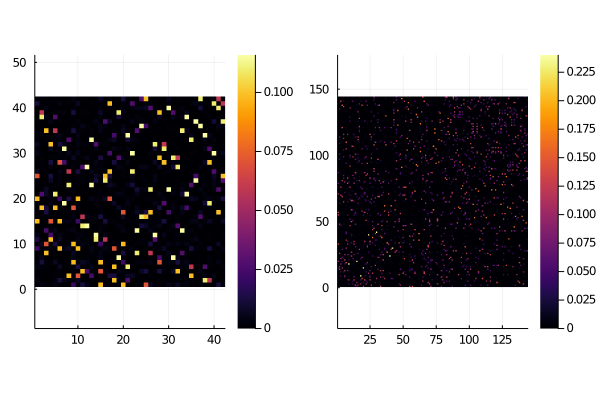

In [5]:
#
# Using these orbitals, let's semi-algorithmically cluster the system. 
# We'll start by separately looking at the π and σ spaces
# Using these orbital orderings, we can inspect to see how local the exchange matrix is
h,j,k = FermiCG.pyscf_get_jk(mol, C[:,1:tot_na] * C[:,1:tot_na]');

k1 = Cact'*(k)*Cact
k2 = Csig'*(k)*Csig
k1 = k1 - Diagonal(diag(k1))
k2 = k2 - Diagonal(diag(k2))
p1 = heatmap(abs.(k1), aspect_ratio=:equal)
p2 = heatmap(abs.(k2), aspect_ratio=:equal)
plot(p1, p2, layout = @layout [a  b])

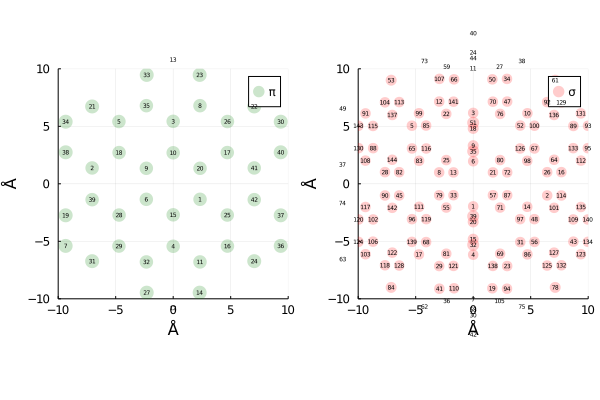

In [6]:
# 
# We can also inspect the orbital positions by looking at <r> and <r⋅r>
pymol = FermiCG.make_pyscf_mole(mol);
r1 = pymol.intor_symmetric("int1e_r");
r2 = pymol.intor_symmetric("int1e_r2");
rx_act = Cact'*r1[1,:,:]*Cact;
ry_act = Cact'*r1[2,:,:]*Cact;
rz_act = Cact'*r1[3,:,:]*Cact;
rx_sig = Csig'*r1[1,:,:]*Csig;
ry_sig = Csig'*r1[2,:,:]*Csig;
rz_sig = Csig'*r1[3,:,:]*Csig;
r2_act = Cact'*r2*Cact;
r2_sig = Csig'*r2*Csig;

var_act = diag(r2_act) - diag(rx_act).*diag(rx_act)- diag(ry_act).*diag(ry_act)- diag(rz_act).*diag(rz_act)
var_sig = diag(r2_sig) - diag(rx_sig).*diag(rx_sig)- diag(ry_sig).*diag(ry_sig)- diag(rz_sig).*diag(rz_sig)


p1 = scatter(diag(rx_act), diag(ry_act), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_act), 
    labels="π",xlims=(-10,10),ylims=(-10,10),  legendfont = font(8),    
    markeralpha = 0.2,
    markercolor = :green,
    markerstrokewidth = 0,
)

[annotate!(rx_act[i,i],ry_act[i,i],i, font(4)) for i in 1:size(rx_act,1)]

p2 = scatter(diag(rx_sig), diag(ry_sig), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_sig), 
    labels="σ",xlims=(-10,10),ylims=(-10,10),     
    markeralpha = 0.2,
    markercolor = :red,
    markerstrokewidth = 0,
)
[annotate!(rx_sig[i,i],ry_sig[i,i],i, font(4)) for i in 1:size(rx_sig,1)]

# p3 = scatter([diag(rx_act), diag(rx_sig)], [diag(ry_act), diag(ry_sig)], aspect_ratio=:equal, 
#     markersize=5*sqrt.([var_act..., var_sig...]), 
#     labels="σ",xlims=(-10,10),ylims=(-10,10),     
#     markeralpha = 0.2,
#     markercolor = :red,
#     markerstrokewidth = 0,
# )
# [annotate!(rx_sig[i,i],ry_sig[i,i],i, font(4)) for i in 1:size(rx_sig,1)]

plot(p1, p2, layout = @layout [a  b]
)
xlabel!("Å")
ylabel!("Å")

# 
# x and y axes are in units of Å. Each point corresponds to the mean position of the orbital, and the marker size 
# is 2*log(<r⋅r>). Thus, larger dots are more diffuse.

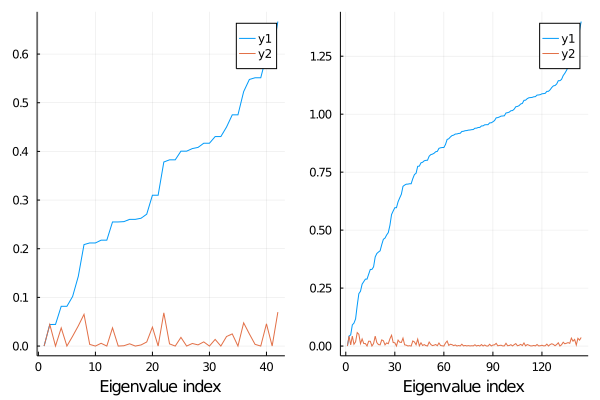

In [11]:
#
# From here, we could manually cluster. But we can instead try to use a k-means approach to spectral clustering. 
using Clustering
using SpectralClustering
# h,j,k = FermiCG.pyscf_get_jk(mol, C[:,1:tot_na] * C[:,1:tot_na]');


k1 = Cact'*(k)*Cact;
k2 = Csig'*(k)*Csig;

nvecs = 7
A = abs.(k1)
L = Diagonal([sum(A[i,:]) for i in 1:size(A,1)]) - A;
F = eigen(L);
p1 = plot(F.values, xlabel="Eigenvalue")
p1 = plot!( [0,[F.values[i+1]-F.values[i] for i in 1:length(F.values)-1]...], xlabel="Eigenvalue index")

A_act = F.vectors[:,1:nvecs]*F.vectors[:,1:nvecs]'
clustering_act = clusterize(KMeansClusterizer(nvecs), A_act).assignments;
perm_act = sortperm(clustering_act)
p2 = heatmap(A_act, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")
A_act = A_act[perm_act, perm_act]
p3 = heatmap(A_act, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")

Cact_sorted = Cact[:,perm_act]

nvecs = 7
A = abs.(k2)
L = Diagonal([sum(A[i,:]) for i in 1:size(A,1)]) - A;
F = eigen(L);
p4 = plot( F.values, xlabel="Eigenvalue index")
p4 = plot!( [0,[F.values[i+1]-F.values[i] for i in 1:length(F.values)-1]...], xlabel="Eigenvalue index")
A_sig = F.vectors[:,1:nvecs]*F.vectors[:,1:nvecs]'
p5 = heatmap(A_sig, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")

clustering_sig = clusterize(KMeansClusterizer(nvecs), A_sig).assignments;
perm_sig = sortperm(clustering_sig)
A_sig = A_sig[perm_sig, perm_sig]
p6 = heatmap(A_sig, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")

Csig_sorted = Csig[:,perm_sig]


FermiCG.pyscf_write_molden(mol, Cact_sorted, filename="act_sorted.molden");
FermiCG.pyscf_write_molden(mol, Csig_sorted, filename="sig_sorted.molden");
plot(p1, p4,  layout = @layout [a  b] )

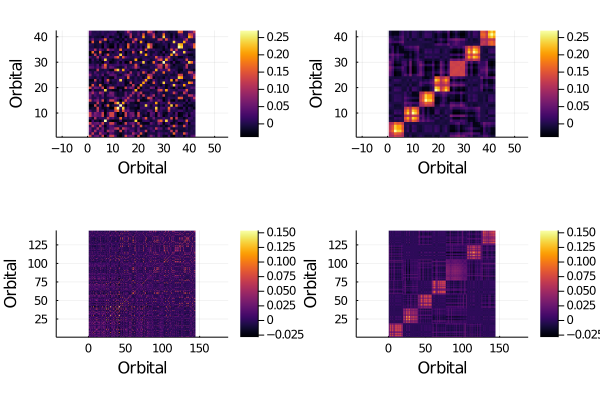

In [12]:
plot(p2, p3, p5, p6, layout = @layout [a  b ;c d])

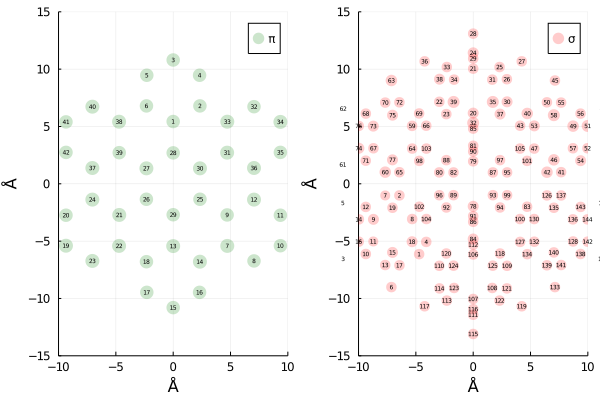

In [14]:
# 
# Now compare labelling
rx_act = Cact_sorted'*r1[1,:,:]*Cact_sorted;
ry_act = Cact_sorted'*r1[2,:,:]*Cact_sorted;
rx_sig = Csig_sorted'*r1[1,:,:]*Csig_sorted;
ry_sig = Csig_sorted'*r1[2,:,:]*Csig_sorted;
r2_act = Cact_sorted'*r2*Cact_sorted;
r2_sig = Csig_sorted'*r2*Csig_sorted;



p1 = scatter(diag(rx_act), diag(ry_act), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_act), 
    labels="π",xlims=(-10,10),ylims=(-15,15),  legendfont = font(8),    
    markeralpha = 0.2,
    markercolor = :green,
    markerstrokewidth = 0,
)



[annotate!(rx_act[i,i],ry_act[i,i],i, font(4)) for i in 1:size(rx_act,1)]

p2 = scatter(diag(rx_sig), diag(ry_sig), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_sig), 
    labels="σ",xlims=(-10,10),ylims=(-15,15),     
    markeralpha = 0.2,
    markercolor = :red,
    markerstrokewidth = 0,
    lw = 1
)

[annotate!(rx_sig[i,i],ry_sig[i,i],i, font(4)) for i in 1:size(rx_sig,1)]

plot(p1, p2, layout = @layout [a  b]
)
xlabel!("Å")
ylabel!("Å")

# 
# x and y axes are in units of Å. Each point corresponds to the mean position of the orbital, and the marker size 
# is 2*log(<r⋅r>). Thus, larger dots are more diffuse.

In [15]:
#
# Build Integrals
ints = FermiCG.pyscf_build_ints(mol, Cact_sorted, 2.0*Cocc*Cocc');
@printf(" Ecore: %12.8f", ints.h0)

 Ecore: -1459.77999732

In [20]:
#
# Define the clusters. These are tuples of orbital ranges.
clusters    = [(1:6), (7:12), (13:18), (19:24), (25:30), (31:36), (37:42)]

#
# Define the reference fock sectors. These are tuples of α, β electron counts.
# For the target clustering where we have 3 "benzene's", we'll have 6 electrons in each cluster.
init_fspace = [(3, 3),(3, 3),(3, 3),(3, 3),(3, 3),(3, 3),(3, 3)]

na = sum([i[1] for i in init_fspace]);
nb = sum([i[2] for i in init_fspace]);
ints.h0


-1459.7799973178599

In [21]:
# define clusters
clusters = [Cluster(i,collect(clusters[i])) for i = 1:length(clusters)]
display(clusters)

rdm1 = zeros(size(ints.h1))

e_cmf, U, Da, Db  = FermiCG.cmf_oo(ints, clusters, init_fspace, rdm1,
                                        max_iter_oo=40, verbose=0, gconv=1e-6, method="bfgs");


7-element Array{Cluster,1}:
 Cluster(1, [1, 2, 3, 4, 5, 6])
 Cluster(2, [7, 8, 9, 10, 11, 12])
 Cluster(3, [13, 14, 15, 16, 17, 18])
 Cluster(4, [19, 20, 21, 22, 23, 24])
 Cluster(5, [25, 26, 27, 28, 29, 30])
 Cluster(6, [31, 32, 33, 34, 35, 36])
 Cluster(7, [37, 38, 39, 40, 41, 42])

 ooCMF Iter:    1 Total= -1581.961100390318 Active= -122.181103072458 G=     1.09e+00
 ooCMF Iter:    2 Total= -1582.309967425823 Active= -122.529970107963 G=     3.38e-01
 ooCMF Iter:    3 Total= -1582.338283453763 Active= -122.558286135903 G=     9.52e-02
 ooCMF Iter:    4 Total= -1582.340435714541 Active= -122.560438396682 G=     3.48e-02
 ooCMF Iter:    5 Total= -1582.340855968208 Active= -122.560858650348 G=     2.80e-02
 ooCMF Iter:    6 Total= -1582.341239425973 Active= -122.561242108113 G=     2.71e-02
 ooCMF Iter:    7 Total= -1582.341453718147 Active= -122.561456400288 G=     1.01e-02
 ooCMF Iter:    8 Total= -1582.341475041778 Active= -122.561477723918 G=     3.49e-03
 ooCMF Iter:    9 Total= -1582.341477745248 Active= -122.561480427388 G=     1.98e-03
 ooCMF Iter:   10 Total= -1582.341479398917 Active= -122.561482081057 G=     1.66e-03
 ooCMF Iter:   11 Total= -1582.341480340472 Active= -122.561483022612 G=     1.33e-03
 ooCMF Iter:   12 Total= -1582.341480901026 Active= -1

 * Status: success

 * Candidate solution
    Final objective value:     -1.582341e+03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.36e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.25e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.12e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.60e-14 ≰ 0.0e+00
    |g(x)|                 = 6.18e-07 ≤ 1.0e-06

 * Work counters
    Seconds run:   168  (vs limit Inf)
    Iterations:    21
    f(x) calls:    43
    ∇f(x) calls:   43


 ooCMF Iter:   22 Total= -1582.341481191164 Active= -122.561483873304 G=     5.25e-06
*ooCMF -1582.34148119 


In [22]:
# Save molden file and rotate integrals
FermiCG.pyscf_write_molden(mol,Cact_sorted*U,filename="cmf.molden");
ints = FermiCG.orbital_rotation(ints,U);

In [23]:

max_roots = 100

#
# Build Cluster basis
cluster_bases = FermiCG.compute_cluster_eigenbasis(ints, clusters, verbose=0, max_roots=max_roots,
        init_fspace=init_fspace, rdm1a=Da, rdm1b=Db);

In [54]:
#
# Build ClusteredOperator
clustered_ham = FermiCG.extract_ClusteredTerms(ints, clusters);


 Remove duplicates
 Number of terms reduced from  9667 to  4039


In [52]:
# for (ftrans, terms) in clustered_ham
#     for term in terms
#         if length(term.clusters) == 2
#             F = svd(term.ints)
#             nkeep = 0
#             for i in F.S
#                 if i > 1e-3
#                     nkeep += 1
#                 end
#             end
#             term.ints .= F.U[:,1:nkeep] * Diagonal(F.S[1:nkeep]) * F.Vt[1:nkeep,:]
            
#             @printf(" Tot: %4i Keep: %4i\n", length(F.S), nkeep)
#         end
#     end
# end

 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:   36 Keep:    0
 Tot:   36 Keep:    4
 Tot:    6 Keep:    6
 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:    6 Keep:    2
 Tot:    6 Keep:    2
 Tot:    6 Keep:    2
 Tot:    6 Keep:    2
 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:    6 Keep:    6
 Tot:   36 Keep:    4
 Tot:   36 Keep:    4
 Tot:   36 Keep:    4
 Tot:   36 Keep:    4
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:   36 Keep:    4
 Tot:   36 Keep:    9
 Tot:   36 Keep:    4
 Tot:   36 Keep:    0
 Tot:   36 Keep:    0
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:   36 Keep:    0
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:   36 Keep:    4
 Tot:   36 Keep:    0
 Tot:   36 Keep:    9
 Tot:   36

 Tot:   36 Keep:    0
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:   36 Keep:    9
 Tot:   36 Keep:    0
 Tot:   36 Keep:    4
 Tot:   36 Keep:    0
 Tot:   36 Keep:    0
 Tot:   36 Keep:    4
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:   36 Keep:    0
 Tot:   36 Keep:    4
 Tot:   36 Keep:    0
 Tot:   36 Keep:    4
 Tot:   36 Keep:    4
 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:    6 Keep:    4
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:    6 Keep:    6
 Tot:   36 Keep:    6
 Tot:   36 Keep:    5
 Tot:   36 Keep:    3
 Tot:   36 Keep:    3
 Tot:   36 Keep:    7
 Tot:   36 Keep:    9
 Tot:   36 Keep:    3
 Tot:   36 Keep:    7
 Tot:   36

In [25]:
# Build Cluster Operators
cluster_ops = FermiCG.compute_cluster_ops(cluster_bases, ints);

In [26]:
p_spaces = Vector{FermiCG.ClusterSubspace}()
q_spaces = Vector{FermiCG.ClusterSubspace}()

# define p spaces
for ci in clusters
    tss = FermiCG.ClusterSubspace(ci)
    tss[init_fspace[ci.idx]] = 1:1
    push!(p_spaces, tss)
end

# define q spaces
for tssp in p_spaces
    tss = FermiCG.get_ortho_compliment(tssp, cluster_bases[tssp.cluster.idx])
    push!(q_spaces, tss)
end

println(" ================= Cluster P Spaces ===================")
display.(p_spaces);
println(" ================= Cluster Q Spaces ===================")
display.(q_spaces);

 ================= Cluster P Spaces ===================
 Subspace for Cluster:    1 : IDX001:DIM4096:001|002|003|004|005|006|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    2 : IDX002:DIM4096:007|008|009|010|011|012|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    3 : IDX003:DIM4096:013|014|015|016|017|018|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    4 : IDX004:DIM4096:019|020|021|022|023|024|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    5 : IDX005:DIM4096:025|026|027|028|029|030|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    6 : IDX006:DIM4096:031|032|033|034|035|036|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    7 : IDX007:DIM4096:037|038|039|040|041|042|
      (3, 3)   Range:    1 → 1    Dim    1
 ================= Cluster Q Spaces ===================
 Subspace for Cluster:    1 : IDX001:DIM4096:001|002|003|004|005|006|
      (0, 0)   Range:    1 

      (3, 1)   Range:    1 → 100  Dim  100
      (4, 5)   Range:    1 → 90   Dim   90
      (4, 0)   Range:    1 → 15   Dim   15
      (2, 4)   Range:    1 → 100  Dim  100
      (6, 5)   Range:    1 → 6    Dim    6
      (1, 2)   Range:    1 → 90   Dim   90
      (5, 1)   Range:    1 → 36   Dim   36
      (3, 4)   Range:    1 → 100  Dim  100
      (2, 3)   Range:    1 → 100  Dim  100
      (2, 6)   Range:    1 → 15   Dim   15
      (0, 5)   Range:    1 → 6    Dim    6
      (5, 4)   Range:    1 → 90   Dim   90
      (2, 1)   Range:    1 → 90   Dim   90
      (2, 5)   Range:    1 → 90   Dim   90
      (1, 4)   Range:    1 → 90   Dim   90
      (0, 1)   Range:    1 → 6    Dim    6
      (0, 6)   Range:    1 → 1    Dim    1
      (1, 1)   Range:    1 → 36   Dim   36
      (2, 2)   Range:    1 → 100  Dim  100
      (5, 0)   Range:    1 → 6    Dim    6
      (6, 3)   Range:    1 → 20   Dim   20
      (2, 0)   Range:    1 → 15   Dim   15
      (6, 1)   Range:    1 → 6    Dim    6
      (1, 3

In [27]:
nroots = 1
ref_vector = FermiCG.TuckerState(clusters, p_spaces, q_spaces, 21, 21)
#
# initialize with eye
FermiCG.set_vector!(ref_vector, Matrix(1.0I, length(ref_vector),nroots))

ref  = FermiCG.CompressedTuckerState(ref_vector, thresh=-1);


In [28]:
# Solve for reference state (should be CMF energy)
@time e_ref, ref = FermiCG.tucker_ci_solve(ref, cluster_ops, clustered_ham, tol=1e-5);
display(ref)

 Iter:   1 SS: 1    E: -122.56148387*  R: 0.0e+00* 
 Memory used by cache: 258496.0
 10.772718 seconds (38.82 M allocations: 1.862 GiB, 10.38% gc time)

 --------------------------------------------------
 ---------- # Fockspaces -------------------:     1  
 ---------- # Configs    -------------------:     1  
 --------------------------------------------------
 Printing contributions greater than: 0.001000
 Weight              # configs (full)    (α,β)...            
 -------             --------- --------- ----------          
 1.000                                   ( 3,3 )( 3,3 )( 3,3 )( 3,3 )( 3,3 )( 3,3 )( 3,3 )
     1.000           1         1             1:1    1:1    1:1    1:1    1:1    1:1    1:1
 ---------                               ----------          
 --------------------------------------------------



In [375]:
# 
# Compute CMF Mean-field Zeroth-Order Hamiltonian
# display(typeof(cluster_ops))
FermiCG.add_cmf_operators!(cluster_ops, cluster_bases, ints, Da, Db);


IDX001:DIM4096:001|002|003|004|005|006|
IDX001:DIM4096:001|002|003|004|005|006|
 FCIProblem:: #Orbs = 6   #α = 0  #β = 0  Dimension: 1        
    1   0.00000000
 FCIProblem:: #Orbs = 6   #α = 3  #β = 6  Dimension: 20       
    1  -4.53409703
    2  -4.26307161
    3  -4.22359872
    4  -4.18100204
    5  -4.17991457
    6  -4.07064573
    7  -4.06982278
    8  -3.96756859
    9  -3.95443056
   10  -3.86436202
   11  -3.80030462
   12  -3.77579730
   13  -3.76489973
   14  -3.65104366
   15  -3.64872152
   16  -3.60126167
   17  -3.59338542
   18  -3.53938042
   19  -3.53809417
   20  -3.30871539
 FCIProblem:: #Orbs = 6   #α = 4  #β = 4  Dimension: 225      
    1  -5.53231926
    2  -5.49925594
    3  -5.49890964
    4  -5.46965528
    5  -5.38563190
    6  -5.38466221
    7  -5.26961034
    8  -5.25886633
    9  -5.22282164
   10  -5.22196910
   11  -5.22094803
   12  -5.20742470
   13  -5.18994477
   14  -5.17704955
   15  -5.17310272
   16  -5.15580339
   17  -5.15167247
   18  -

   29  -4.04767896
   30  -4.04380247
   31  -4.03372846
   32  -4.03370108
   33  -4.02267045
   34  -3.99119717
   35  -3.98792483
   36  -3.95924227
   37  -3.93780435
   38  -3.93217881
   39  -3.91893420
   40  -3.91588760
   41  -3.89312645
   42  -3.87258532
   43  -3.87129312
   44  -3.87070569
   45  -3.87018179
   46  -3.81187457
   47  -3.80990810
   48  -3.79326433
   49  -3.76632620
   50  -3.76603078
   51  -3.76520766
   52  -3.75332893
   53  -3.74223882
   54  -3.73553251
   55  -3.72360775
   56  -3.72225850
   57  -3.71887329
   58  -3.70390643
   59  -3.67946671
   60  -3.66861428
   61  -3.65531780
   62  -3.65254425
   63  -3.65090731
   64  -3.64799835
   65  -3.60492774
   66  -3.59962306
   67  -3.53803546
   68  -3.52328652
   69  -3.50124369
   70  -3.48595583
   71  -3.47542917
   72  -3.44820320
   73  -3.43063752
   74  -3.42730150
   75  -3.41159581
   76  -3.40094000
   77  -3.36605820
   78  -3.35715041
   79  -3.34518019
   80  -3.30064910
   81  -3.29

    1  -5.90699776
    2  -5.89702523
    3  -5.81957318
    4  -5.76907105
    5  -5.76341630
    6  -5.75625142
    7  -5.63571229
    8  -5.63463629
    9  -5.63102765
   10  -5.57007122
   11  -5.56951212
   12  -5.54403804
   13  -5.53547997
   14  -5.50370088
   15  -5.50342007
   16  -5.49157761
   17  -5.48897604
   18  -5.48526573
   19  -5.42375040
   20  -5.36114919
   21  -5.35134122
   22  -5.33634108
   23  -5.33478041
   24  -5.32344144
   25  -5.32325685
   26  -5.32114877
   27  -5.27293497
   28  -5.27001544
   29  -5.23570939
   30  -5.23517694
   31  -5.22680814
   32  -5.22271693
   33  -5.21918034
   34  -5.20608724
   35  -5.20388246
   36  -5.19306095
   37  -5.15632122
   38  -5.15218117
   39  -5.14313997
   40  -5.14194135
   41  -5.11451437
   42  -5.07807160
   43  -5.07481418
   44  -5.02705099
   45  -5.02695541
   46  -5.02395732
   47  -5.01860960
   48  -5.01489874
   49  -4.97124566
   50  -4.97071679
   51  -4.96587634
   52  -4.94534059
   53  -4.92

   14  -5.77519313
   15  -5.76149166
   16  -5.74722141
   17  -5.74100172
   18  -5.71280362
   19  -5.70961359
   20  -5.67781269
   21  -5.66299408
   22  -5.65715411
   23  -5.64172223
   24  -5.64130247
   25  -5.62868796
   26  -5.62560932
   27  -5.62184411
   28  -5.61962919
   29  -5.59020953
   30  -5.58866676
   31  -5.56969503
   32  -5.56504716
   33  -5.53441021
   34  -5.52987419
   35  -5.51526425
   36  -5.51427956
   37  -5.51409734
   38  -5.51351175
   39  -5.51158721
   40  -5.50882042
   41  -5.49966640
   42  -5.49910137
   43  -5.49603520
   44  -5.46940705
   45  -5.46685857
   46  -5.45267897
   47  -5.44807322
   48  -5.44704622
   49  -5.44646286
   50  -5.43138442
   51  -5.43023143
   52  -5.42932672
   53  -5.42773916
   54  -5.41397249
   55  -5.39906778
   56  -5.39351154
   57  -5.39030584
   58  -5.37993175
   59  -5.35665647
   60  -5.35559463
   61  -5.35526768
   62  -5.35037748
   63  -5.35013116
   64  -5.34763496
   65  -5.34067151
   66  -5.33

    1  -6.38846097
    2  -6.23132416
    3  -6.17804704
    4  -6.17215465
    5  -6.16869731
    6  -6.09571444
    7  -6.09301074
    8  -6.05019441
    9  -6.04153990
   10  -6.02493582
   11  -6.02161117
   12  -5.98788112
   13  -5.95100779
   14  -5.95020745
   15  -5.94821194
   16  -5.94540747
   17  -5.94184932
   18  -5.91215602
   19  -5.87634768
   20  -5.86187496
   21  -5.86139027
   22  -5.85780796
   23  -5.85596548
   24  -5.85461576
   25  -5.82202155
   26  -5.81797956
   27  -5.80100484
   28  -5.79949403
   29  -5.79626093
   30  -5.79179302
   31  -5.79095365
   32  -5.75697338
   33  -5.74890952
   34  -5.74595365
   35  -5.74426766
   36  -5.73042137
   37  -5.73030588
   38  -5.72536478
   39  -5.71418010
   40  -5.70575691
   41  -5.70148278
   42  -5.68144439
   43  -5.67469264
   44  -5.67403191
   45  -5.67238537
   46  -5.67203174
   47  -5.67171343
   48  -5.64976798
   49  -5.64526035
   50  -5.63842961
   51  -5.63623104
   52  -5.63585062
   53  -5.63

    1  -5.53231926
    2  -5.49925594
    3  -5.49890964
    4  -5.46965528
    5  -5.38563190
    6  -5.38466221
    7  -5.26961034
    8  -5.25886633
    9  -5.22282164
   10  -5.22196910
   11  -5.22094803
   12  -5.20742470
   13  -5.18994477
   14  -5.17704955
   15  -5.17310272
   16  -5.15580339
   17  -5.15167247
   18  -5.12519930
   19  -5.12001714
   20  -5.11200404
   21  -5.10492501
   22  -5.09985952
   23  -5.08555687
   24  -5.07919600
   25  -5.06586382
   26  -5.03858353
   27  -5.02670445
   28  -5.02495314
   29  -5.01797605
   30  -4.98356385
   31  -4.97833046
   32  -4.97754850
   33  -4.97586491
   34  -4.97385486
   35  -4.95954613
   36  -4.93398194
   37  -4.92671612
   38  -4.92270303
   39  -4.90856790
   40  -4.90463496
   41  -4.88165222
   42  -4.88165182
   43  -4.88107565
   44  -4.88075769
   45  -4.87196459
   46  -4.87029984
   47  -4.85955275
   48  -4.85299867
   49  -4.85085064
   50  -4.84173565
   51  -4.83373165
   52  -4.82613196
   53  -4.80

   52  -3.75332893
   53  -3.74223882
   54  -3.73553251
   55  -3.72360775
   56  -3.72225850
   57  -3.71887329
   58  -3.70390643
   59  -3.67946671
   60  -3.66861428
   61  -3.65531780
   62  -3.65254425
   63  -3.65090731
   64  -3.64799835
   65  -3.60492774
   66  -3.59962306
   67  -3.53803546
   68  -3.52328652
   69  -3.50124369
   70  -3.48595583
   71  -3.47542917
   72  -3.44820320
   73  -3.43063752
   74  -3.42730150
   75  -3.41159581
   76  -3.40094000
   77  -3.36605820
   78  -3.35715041
   79  -3.34518019
   80  -3.30064910
   81  -3.29172235
   82  -3.25661728
   83  -3.25436163
   84  -3.17447171
   85  -3.15002857
   86  -3.09236063
   87  -3.07798136
   88  -3.03975502
   89  -2.98939878
   90  -2.98295594
 FCIProblem:: #Orbs = 6   #α = 5  #β = 1  Dimension: 36       
    1  -6.02161117
    2  -5.94821194
    3  -5.94184932
    4  -5.80100484
    5  -5.79949403
    6  -5.70148278
    7  -5.68144439
    8  -5.67203174
    9  -5.62919776
   10  -5.57367234
   11 

    1  -5.90699776
    2  -5.89702523
    3  -5.81957318
    4  -5.76907105
    5  -5.76341630
    6  -5.75625142
    7  -5.63571229
    8  -5.63463629
    9  -5.63102765
   10  -5.57007122
   11  -5.56951212
   12  -5.54403804
   13  -5.53547997
   14  -5.50370088
   15  -5.50342007
   16  -5.49157761
   17  -5.48897604
   18  -5.48526573
   19  -5.42375040
   20  -5.36114919
   21  -5.35134122
   22  -5.33634108
   23  -5.33478041
   24  -5.32344144
   25  -5.32325685
   26  -5.32114877
   27  -5.27293497
   28  -5.27001544
   29  -5.23570939
   30  -5.23517694
   31  -5.22680814
   32  -5.22271693
   33  -5.21918034
   34  -5.20608724
   35  -5.20388246
   36  -5.19306095
   37  -5.15632122
   38  -5.15218117
   39  -5.14313997
   40  -5.14194135
   41  -5.11451437
   42  -5.07807160
   43  -5.07481418
   44  -5.02705099
   45  -5.02695541
   46  -5.02395732
   47  -5.01860960
   48  -5.01489874
   49  -4.97124566
   50  -4.97071679
   51  -4.96587634
   52  -4.94534059
   53  -4.92

    1  -6.09706799
    2  -6.09444359
    3  -5.98224307
    4  -5.90760014
    5  -5.89773889
    6  -5.87144285
    7  -5.87113447
    8  -5.82574606
    9  -5.82217155
   10  -5.81538677
   11  -5.80981494
   12  -5.80004107
   13  -5.79622444
   14  -5.77519313
   15  -5.76149166
   16  -5.74722141
   17  -5.74100172
   18  -5.71280362
   19  -5.70961359
   20  -5.67781269
   21  -5.66299408
   22  -5.65715411
   23  -5.64172223
   24  -5.64130247
   25  -5.62868796
   26  -5.62560932
   27  -5.62184411
   28  -5.61962919
   29  -5.59020953
   30  -5.58866676
   31  -5.56969503
   32  -5.56504716
   33  -5.53441021
   34  -5.52987419
   35  -5.51526425
   36  -5.51427956
   37  -5.51409734
   38  -5.51351175
   39  -5.51158721
   40  -5.50882042
   41  -5.49966640
   42  -5.49910137
   43  -5.49603520
   44  -5.46940705
   45  -5.46685857
   46  -5.45267897
   47  -5.44807322
   48  -5.44704622
   49  -5.44646286
   50  -5.43138442
   51  -5.43023143
   52  -5.42932672
   53  -5.42

    1  -6.38846097
    2  -6.23132416
    3  -6.17804704
    4  -6.17215465
    5  -6.16869731
    6  -6.09571444
    7  -6.09301074
    8  -6.05019441
    9  -6.04153990
   10  -6.02493582
   11  -6.02161117
   12  -5.98788112
   13  -5.95100779
   14  -5.95020745
   15  -5.94821194
   16  -5.94540747
   17  -5.94184932
   18  -5.91215602
   19  -5.87634768
   20  -5.86187496
   21  -5.86139027
   22  -5.85780796
   23  -5.85596548
   24  -5.85461576
   25  -5.82202155
   26  -5.81797956
   27  -5.80100484
   28  -5.79949403
   29  -5.79626093
   30  -5.79179302
   31  -5.79095365
   32  -5.75697338
   33  -5.74890952
   34  -5.74595365
   35  -5.74426766
   36  -5.73042137
   37  -5.73030588
   38  -5.72536478
   39  -5.71418010
   40  -5.70575691
   41  -5.70148278
   42  -5.68144439
   43  -5.67469264
   44  -5.67403191
   45  -5.67238537
   46  -5.67203174
   47  -5.67171343
   48  -5.64976798
   49  -5.64526035
   50  -5.63842961
   51  -5.63623104
   52  -5.63585062
   53  -5.63

    1  -5.53232729
    2  -5.49926475
    3  -5.49891659
    4  -5.46966346
    5  -5.38563725
    6  -5.38467092
    7  -5.26961688
    8  -5.25887288
    9  -5.22282715
   10  -5.22197243
   11  -5.22095581
   12  -5.20743327
   13  -5.18995129
   14  -5.17705605
   15  -5.17310873
   16  -5.15580764
   17  -5.15168142
   18  -5.12520412
   19  -5.12002162
   20  -5.11201116
   21  -5.10493312
   22  -5.09986664
   23  -5.08556168
   24  -5.07920167
   25  -5.06586963
   26  -5.03858906
   27  -5.02670744
   28  -5.02495921
   29  -5.01798510
   30  -4.98356937
   31  -4.97833602
   32  -4.97755330
   33  -4.97587049
   34  -4.97386123
   35  -4.95955249
   36  -4.93398650
   37  -4.92672148
   38  -4.92270953
   39  -4.90857380
   40  -4.90464054
   41  -4.88165874
   42  -4.88165831
   43  -4.88108069
   44  -4.88075979
   45  -4.87197003
   46  -4.87030647
   47  -4.85955612
   48  -4.85300380
   49  -4.85085523
   50  -4.84174208
   51  -4.83373680
   52  -4.82613750
   53  -4.80

   67  -3.53803734
   68  -3.52329002
   69  -3.50124718
   70  -3.48595912
   71  -3.47543092
   72  -3.44820402
   73  -3.43064007
   74  -3.42730419
   75  -3.41159772
   76  -3.40094406
   77  -3.36606114
   78  -3.35715178
   79  -3.34518308
   80  -3.30064919
   81  -3.29172650
   82  -3.25661954
   83  -3.25436324
   84  -3.17447342
   85  -3.15003075
   86  -3.09236277
   87  -3.07798312
   88  -3.03975533
   89  -2.98940000
   90  -2.98295802
 FCIProblem:: #Orbs = 6   #α = 5  #β = 1  Dimension: 36       
    1  -6.02161734
    2  -5.94821540
    3  -5.94185813
    4  -5.80100891
    5  -5.79950034
    6  -5.70148703
    7  -5.68144909
    8  -5.67203969
    9  -5.62920349
   10  -5.57367834
   11  -5.46238687
   12  -5.46207128
   13  -5.44403899
   14  -5.44246185
   15  -5.37208470
   16  -5.36609886
   17  -5.34536042
   18  -5.33979600
   19  -5.29386675
   20  -5.29299357
   21  -5.23851296
   22  -5.23038076
   23  -5.22254797
   24  -5.21800885
   25  -5.18647829
   26 

    1  -5.90700300
    2  -5.89703460
    3  -5.81958044
    4  -5.76907361
    5  -5.76342360
    6  -5.75626102
    7  -5.63571769
    8  -5.63464248
    9  -5.63103305
   10  -5.57007794
   11  -5.56951670
   12  -5.54404382
   13  -5.53548570
   14  -5.50370795
   15  -5.50342295
   16  -5.49158485
   17  -5.48898190
   18  -5.48527086
   19  -5.42375623
   20  -5.36115351
   21  -5.35134604
   22  -5.33634581
   23  -5.33478534
   24  -5.32344687
   25  -5.32326145
   26  -5.32115545
   27  -5.27293858
   28  -5.27002159
   29  -5.23571382
   30  -5.23518042
   31  -5.22681453
   32  -5.22272357
   33  -5.21918615
   34  -5.20608849
   35  -5.20388873
   36  -5.19306751
   37  -5.15632456
   38  -5.15218796
   39  -5.14314314
   40  -5.14194676
   41  -5.11451937
   42  -5.07807580
   43  -5.07481994
   44  -5.02705367
   45  -5.02695904
   46  -5.02396444
   47  -5.01861556
   48  -5.01490158
   49  -4.97125039
   50  -4.97072001
   51  -4.96588073
   52  -4.94534496
   53  -4.92

    1  -6.09707420
    2  -6.09445432
    3  -5.98225082
    4  -5.90760496
    5  -5.89774823
    6  -5.87145034
    7  -5.87113990
    8  -5.82575263
    9  -5.82217928
   10  -5.81539053
   11  -5.80982209
   12  -5.80004815
   13  -5.79623326
   14  -5.77520036
   15  -5.76149764
   16  -5.74722807
   17  -5.74100839
   18  -5.71280898
   19  -5.70962132
   20  -5.67781821
   21  -5.66300099
   22  -5.65715967
   23  -5.64172739
   24  -5.64130838
   25  -5.62869394
   26  -5.62561584
   27  -5.62185171
   28  -5.61963755
   29  -5.59021603
   30  -5.58867142
   31  -5.56970051
   32  -5.56505481
   33  -5.53441526
   34  -5.52987937
   35  -5.51527063
   36  -5.51428538
   37  -5.51410245
   38  -5.51351587
   39  -5.51159296
   40  -5.50882293
   41  -5.49967086
   42  -5.49910942
   43  -5.49604242
   44  -5.46941301
   45  -5.46686456
   46  -5.45268477
   47  -5.44807917
   48  -5.44705252
   49  -5.44646825
   50  -5.43139009
   51  -5.43023818
   52  -5.42933385
   53  -5.42

    1  -6.38846998
    2  -6.23133087
    3  -6.17805488
    4  -6.17216211
    5  -6.16870578
    6  -6.09572088
    7  -6.09301906
    8  -6.05019741
    9  -6.04155068
   10  -6.02494435
   11  -6.02161734
   12  -5.98788870
   13  -5.95101735
   14  -5.95021510
   15  -5.94821540
   16  -5.94541309
   17  -5.94185813
   18  -5.91216265
   19  -5.87635389
   20  -5.86188122
   21  -5.86139611
   22  -5.85781673
   23  -5.85597088
   24  -5.85462226
   25  -5.82202744
   26  -5.81798874
   27  -5.80100891
   28  -5.79950034
   29  -5.79626808
   30  -5.79180057
   31  -5.79095931
   32  -5.75697728
   33  -5.74891978
   34  -5.74596032
   35  -5.74427472
   36  -5.73042683
   37  -5.73031142
   38  -5.72537178
   39  -5.71418927
   40  -5.70576391
   41  -5.70148703
   42  -5.68144909
   43  -5.67469978
   44  -5.67403767
   45  -5.67239230
   46  -5.67203969
   47  -5.67171985
   48  -5.64977409
   49  -5.64526398
   50  -5.63843608
   51  -5.63623703
   52  -5.63585748
   53  -5.63

In [38]:
# Solve for target
using StatProfilerHTML
@profilehtml e_var, v_var = FermiCG.solve_for_compressed_space(ref, cluster_ops, clustered_ham, 
    nbody=2, 
    H0="H",
    thresh_var=1e-3, 
    thresh_foi=1e-6, 
    thresh_pt =1e-6, 
    do_pt = false,
    tol_ci=1e-5, 
    tol_tucker=1e-5);

 --------------------------------------------------------------------
 Iterate PT-Var:       Iteration #: 1
 --------------------------------------------------------------------
 Compressed Ref state from:        1 →        1 (thresh =  1.0e-03)
 Norm of compressed state:   1.00000000 

 Solve zeroth-order problem. Dimension =          1
 Iter:   1 SS: 1    E: -122.56148387*  R: 0.0e+00* 
 Memory used by cache: 258496.0
  4.713780 seconds (2.78 M allocations: 98.404 MiB, 1.01% gc time)

 Compute first order wavefunction. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 2
 Norm |0>:   1.00000000
 <0|H0|0>: -200.67095162
  4.022003 seconds (1.73 M allocations: 1.390 GiB, 7.09% gc time)
 FOIS Compressed from:        13366 →     2085 (thresh =  1.0e-06)
 Norm of |1>:                0.32331467 
 Overlap between <1|0>:     0.0e+00

 Solve in compressed FOIS. Dimension =         2086
 Iter:   1 SS: 1    E: -122.31718144   R: 4.2e-01  


 Iter:   2 SS: 2    E: -122.58053471   R: 1.8e-01  
 Iter:   3 SS: 3    E: -122.62203521   R: 8.6e-02  
 Iter:   4 SS: 4    E: -122.62953413   R: 2.3e-02  
 Iter:   5 SS: 5    E: -122.63012923   R: 8.2e-03  
 Iter:   6 SS: 6    E: -122.63021831   R: 3.1e-03  
 Iter:   7 SS: 7    E: -122.63022830   R: 1.0e-03  
 Iter:   8 SS: 8    E: -122.63022954   R: 3.4e-04  
 Iter:   9 SS: 9    E: -122.63022966   R: 1.2e-04  
 Iter:  10 SS: 10   E: -122.63022968   R: 3.5e-05  
 Iter:  11 SS: 11   E: -122.63022968*  R: 1.0e-05* 
 Memory used by cache: 258496.0
 50.835115 seconds (164.24 M allocations: 12.227 GiB, 10.21% gc time)
 E(Ref)      = -122.56148387
 E(var) tot  = -122.63022968
 --------------------------------------------------------------------
 Iterate PT-Var:       Iteration #: 2
 --------------------------------------------------------------------
 Compressed Ref state from:     2086 →       25 (thresh =  1.0e-03)
 Norm of compressed state:   1.00000000 

 Solve zeroth-order problem. Dim

┌ Info: You interrupted the computation; generating profiling view for the computation so far.
└ @ Main /Users/nmayhall/.julia/packages/StatProfilerHTML/yoDm8/src/StatProfilerHTML.jl:35
┌ Info: Wrote profiling output to file:///Users/nmayhall/code/FermiCG/statprof/index.html .
└ @ StatProfilerHTML /Users/nmayhall/.julia/packages/StatProfilerHTML/yoDm8/src/StatProfilerHTML.jl:25


In [ ]:
# Solve for target
@time e_var, v_var = FermiCG.solve_for_compressed_space(v_var, cluster_ops, clustered_ham, 
    nbody=4, 
    H0="H",
    thresh_var=1e-2, 
    thresh_foi=1e-6, 
    tol_ci=1e-5, 
    tol_tucker=1e-5);

In [ ]:
# Solve for target
@time e_var, v_var = FermiCG.solve_for_compressed_space(v_var, cluster_ops, clustered_ham, 
    nbody=4, 
    H0="H",
    thresh_var=1e-3, 
    thresh_foi=1e-5, 
    tol_ci=1e-5, 
    tol_tucker=1e-5);

In [53]:
 e_cepa, v_cepa = FermiCG.do_fois_cepa(ref, cluster_ops, clustered_ham, thresh_foi=1e-6);


 Solve zeroth-order problem. Dimension =          1
 Iter:   1 SS: 1    E: -122.56020611*  R: 0.0e+00* 
 Memory used by cache: 258496.0
  0.049424 seconds (18.59 k allocations: 922.109 KiB)

 Compute FOIS. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 4
 Norm |0>:   1.00000000
 <0|H0|0>: -200.67095162
 60.042383 seconds (8.30 M allocations: 3.870 GiB, 82.01% gc time)
 FOIS Compressed from:        14920 →     3303 (thresh =  1.0e-06)
 Norm of |1>:                0.07191386 
 Overlap between <1|0>:     0.0e+00
 E(PT2) corr =                    0.07073337

 Do CEPA: Dim = 3303
 Reference Energy: -122.56020611
 Overlap between <1|0>:           0.0e+00
 Norm of Sx overlap:   0.00000000
 Now flushing:
 Start CEPA iterations with dimension = 3303
  1	7.39e-02
  2	4.46e-02
  3	1.69e-02
  4	6.13e-03
  5	2.36e-03
  6	7.83e-04
  7	3.00e-04
  8	1.25e-04
  9	4.24e-05
 10	1.16e-05
 11	3.46e-06

 Now flushing:
 <A|X>C(X) =   0.00000000
 Cepa:  -0.0885

In [35]:
 e_cepa, v_cepa = FermiCG.do_fois_cepa(ref, cluster_ops, clustered_ham, thresh_foi=1e-6);



 Solve zeroth-order problem. Dimension =          1
 Iter:   1 SS: 1    E: -122.56148387*  R: 0.0e+00* 
 Memory used by cache: 258496.0
  0.152707 seconds (113.81 k allocations: 4.674 MiB)

 Compute FOIS. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 4
 Norm |0>:   1.00000000
 <0|H0|0>: -200.67095162
  6.767938 seconds (8.30 M allocations: 3.886 GiB, 12.35% gc time)
 FOIS Compressed from:        15010 →     3393 (thresh =  1.0e-06)
 Norm of |1>:                0.07189966 
 Overlap between <1|0>:     0.0e+00
 E(PT2) corr =                    0.07072694

 Do CEPA: Dim = 3393
 Reference Energy: -122.56148387
 Overlap between <1|0>:           0.0e+00
 Norm of Sx overlap:   0.00000000
 Now flushing:
 Start CEPA iterations with dimension = 3393
  1	7.40e-02
  2	4.48e-02
  3	1.69e-02
  4	6.14e-03
  5	2.37e-03
  6	7.88e-04
  7	3.01e-04
  8	1.26e-04
  9	4.25e-05
 10	1.16e-05
 11	3.50e-06

 Now flushing:
 <A|X>C(X) =   0.00000000
 Cepa:  -0.08864

In [36]:
 e_cepa, v_cepa = FermiCG.do_fois_cepa(ref, cluster_ops, clustered_ham, thresh_foi=1e-7);



 Solve zeroth-order problem. Dimension =          1
 Iter:   1 SS: 1    E: -122.56148387*  R: 0.0e+00* 
 Memory used by cache: 258496.0
  0.008057 seconds (18.60 k allocations: 922.141 KiB)

 Compute FOIS. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 4
 Norm |0>:   1.00000000
 <0|H0|0>: -200.67095162
  7.246614 seconds (8.46 M allocations: 3.951 GiB, 13.17% gc time)
 FOIS Compressed from:        31225 →    16248 (thresh =  1.0e-07)
 Norm of |1>:                0.07150534 
 Overlap between <1|0>:     0.0e+00
 E(PT2) corr =                    0.07152566

 Do CEPA: Dim = 16248
 Reference Energy: -122.56148387
 Overlap between <1|0>:           0.0e+00
 Norm of Sx overlap:   0.00000000
 Now flushing:
 Start CEPA iterations with dimension = 16248
  1	8.59e-02
  2	5.72e-02
  3	2.70e-02
  4	1.06e-02
  5	4.96e-03
  6	2.21e-03
  7	8.38e-04
  8	3.32e-04
  9	1.59e-04
 10	6.72e-05
 11	2.55e-05
 12	9.23e-06

 Now flushing:
 <A|X>C(X) =   0.00000000


In [39]:
 @profilehtml e_cepa, v_cepa = FermiCG.do_fois_cepa(ref, cluster_ops, clustered_ham, thresh_foi=1e-8);


 Solve zeroth-order problem. Dimension =          1
 Iter:   1 SS: 1    E: -122.56148387*  R: 0.0e+00* 
 Memory used by cache: 258496.0
  3.607569 seconds (1.78 M allocations: 64.889 MiB, 0.54% gc time)

 Compute FOIS. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 4
 Norm |0>:   1.00000000
 <0|H0|0>: -200.67095162
  9.771709 seconds (8.55 M allocations: 4.028 GiB, 12.31% gc time)
 FOIS Compressed from:     

   76156 →    54663 (thresh =  1.0e-08)
 Norm of |1>:                0.07187148 
 Overlap between <1|0>:     0.0e+00
 E(PT2) corr =                    0.07187223

 Do CEPA: Dim = 54663
 Reference Energy: -122.56148387
 Overlap between <1|0>:           0.0e+00
 Norm of Sx overlap:   0.00000000
 Now flushing:
 Start CEPA iterations with dimension = 54663
  1	9.99e-02
  2	6.94e-02
  3	4.12e-02
  4	1.85e-02
  5	9.37e-03
  6	4.79e-03
  7	2.10e-03
  8	9.35e-04
  9	4.26e-04
 10	2.24e-04
 11	1.26e-04
 12	5.92e-05
 13	2.51e-05
 14	9.98e-06

 Now flushing:
 <A|X>C(X) =   0.00000000
 Cepa:  -0.10164463
 E(CEPA) = -122.66312850
2847.730616 seconds (15.63 G allocations: 903.699 GiB, 16.24% gc time)
 E(cepa) corr =                 -122.66312850
 X(cepa) norm =                   0.46381529


┌ Info: Wrote profiling output to file:///Users/nmayhall/code/FermiCG/statprof/index.html .
└ @ StatProfilerHTML /Users/nmayhall/.julia/packages/StatProfilerHTML/yoDm8/src/StatProfilerHTML.jl:25


In [43]:
 e_cepa, v_cepa = FermiCG.do_fois_cepa(ref, cluster_ops, clustered_ham, thresh_foi=1e-9);


 Solve zeroth-order problem. Dimension =          1
 Iter:   1 SS: 1    E: -122.56148387*  R: 0.0e+00* 
 Memory used by cache: 258496.0
  0.009683 seconds (18.85 k allocations: 965.422 KiB)

 Compute FOIS. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 4
 Norm |0>:   1.00000000
 <0|H0|0>: -200.67095162
  7.322562 seconds (8.62 M allocations: 4.120 GiB, 13.51% gc time)
 FOIS Compressed from:       284005 →   248544 (thresh =  1.0e-09)
 Norm of |1>:                0.07191825 
 Overlap between <1|0>:     0.0e+00
 E(PT2) corr =                    0.07191920

 Do CEPA: Dim = 248544
 Reference Energy: -122.56148387
 Overlap between <1|0>:           0.0e+00
 Norm of Sx overlap:   0.00000000
 Now flushing:
 Start CEPA iterations with dimension = 248544
  1	1.07e-01
  2	7.47e-02
  3	4.98e-02
  4	2.53e-02
  5	1.31e-02
  6	7.15e-03
  7	3.70e-03
  8	1.81e-03
  9	8.64e-04
 10	4.38e-04
 11	2.51e-04
 12	1.45e-04
 13	7.44e-05
 14	3.42e-05
 15	1.56e-05
 

In [346]:
# Solve for reference state (should be CMF energy)
@time e_final, v_final = FermiCG.tucker_ci_solve(v_var, cluster_ops, clustered_ham, tol=1e-5);
display(v_final)

 Iter:   1 SS: 1    E:  -33.06539516   R: 5.9e-03  
 Iter:   2 SS: 2    E:  -33.06544544   R: 2.6e-03  
 Iter:   3 SS: 3    E:  -33.06545775   R: 7.0e-04  
 Iter:   4 SS: 4    E:  -33.06545855   R: 2.0e-04  
 Iter:   5 SS: 5    E:  -33.06545858   R: 2.0e-05  
 Iter:   6 SS: 6    E:  -33.06545858*  R: 8.0e-06* 
 Memory used by cache: 10176.0
  1.409862 seconds (1.12 M allocations: 208.136 MiB, 3.45% gc time)

 --------------------------------------------------
 ---------- # Fockspaces -------------------:    19  
 ---------- # Configs    -------------------:    82  
 --------------------------------------------------
 Printing contributions greater than: 0.001000
 Weight              # configs (full)    (α,β)...            
 -------             --------- --------- ----------          
 0.971                                   ( 3,3 )( 3,3 )( 3,3 )
     0.965           1         1             1:1    1:1    1:1
     0.002           9         9801        2:100    1:1  2:100
     0.002      